In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import datetime
import json
import tensorflow as tf
from tqdm.keras import TqdmCallback
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.losses import SparseCategoricalCrossentropy

sns.set_theme()

try: # are we in Colab?
    import google.colab
    COMPUTE_ENV = 'colab'
    print('Running in Colab.')
    google.colab.drive.mount('/content/gdrive')
    OUTPUT_DIR = "/content/gdrive/My Drive/output"
    !git clone https://github.com/FriedChips/dl_basics.git
    sys.path.insert(0,'/content/dl_basics')
except: # if not...
    if "kaggle" in os.environ["PWD"]: # are we in Kaggle?
        COMPUTE_ENV = 'kaggle'
        print('Running in Kaggle.')
        !git clone https://github.com/FriedChips/dl_basics.git
        sys.path.insert(0,'../working/dl_basics')    
        OUTPUT_DIR = "./"
    else: # we're local
        COMPUTE_ENV = os.uname()[1]
        print(f"Running locally on {COMPUTE_ENV}.")
        sys.path.insert(0,'./../')
        OUTPUT_DIR = "../output/"

for gpu in tf.config.list_physical_devices("GPU"):
    print(f"Found GPU: {tf.config.experimental.get_device_details(gpu)['device_name']}.")

2023-04-20 16:56:59.764792: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Running locally on beta.


In [2]:
from data_gen.modulo_arithmetic import addition_modulo_data
#import models
import utils

In [3]:
P = {}

P["addition_modulo_data"] = {
    "p_max" : 113,
    "train_size" : 0.3,
    "add_equal_sign" : False,
    "seed" : 42,
}

x_train, x_val, y_train, y_val = addition_modulo_data(**P["addition_modulo_data"])
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)
print(x_train.dtype, x_val.dtype, y_train.dtype, y_val.dtype)
print(x_train[0], y_train[0])

(3830, 2) (8939, 2) (3830,) (8939,)
int32 int32 int32 int32
[24 37] 61


In [4]:
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Embedding, Dense, Conv2D, Flatten
from tensorflow.keras.regularizers import L2
from models.transformers import transformer_block

def mlp_mod_arith(
        seq_len,
        vocab_size,
        embed_dim,
        mlp_dim,
        regularizer=None,
):
    if regularizer is not None:
        regularizer = eval(regularizer)

    inp = Input(shape=(seq_len,), dtype=np.int32, name="input")
    x = Embedding(vocab_size, embed_dim, input_length=seq_len, embeddings_regularizer=regularizer, name="embedding")(inp)
    x = tf.expand_dims(x, -1)
    x = Conv2D(mlp_dim, kernel_size=(seq_len, embed_dim), use_bias=False, kernel_regularizer=regularizer, name="mlp")(x)
    x = tf.nn.gelu(x)
    x = Flatten()(x)
    x = Dense(vocab_size, use_bias=False, kernel_regularizer=regularizer, name="unembedding")(x)
    out = x
    
    model = Model(inp, out, name="mlp_mod_arith")
    return model


def transf_mod_arith(
        seq_len,
        vocab_size,
        embed_dim,
        use_bias=False,
):
    inp = Input(shape=(seq_len,), dtype=np.int32, name="input")
    x = Embedding(vocab_size, embed_dim, input_length=seq_len, name="embedding")(inp)
    x = transformer_block(x, num_heads=1, use_mlp=True, mlp_factor=1, use_bias=use_bias)
    x = Dense(vocab_size, use_bias=use_bias, name="unembedding")(x)
    out = x[..., -1, :]

    model = Model(inp, out, name="transf_mod_arith")
    return model

In [5]:
# init new run

'''
P["model_name"] = "gru_01"
P["model_build_params"] = {
    "gru_units" : 128,
    "num_outputs" : P["addition_modulo_data"]["p_max"],
    "input_shape" : (2,),
    "num_hidden_gru" : 0,
    "use_embedding" : True,
    "vocab_size" : P["addition_modulo_data"]["p_max"],
    "embedding_dim" : 128,
    "return_final_hidden" : True,
}

P["model_name"] = "transformer_01"
P["model_build_params"] = {
    "input_shape" : (3,),
    "num_heads" : 4,
    "num_tokens" : P["addition_modulo_data"]["p_max"] + 1, # + 1 for the "=" sign
    "embedding_dim" : 128,
    "return_final_token_only" : True,
}
'''

P["model_name"] = "mlp_mod_arith"
P["model_build_params"] = {
    "seq_len" : 2,
    "vocab_size" : P["addition_modulo_data"]["p_max"],
    "embed_dim" : 64,
    "mlp_dim" : 64,
    "regularizer" : None,
}

'''
P["model_name"] = "transf_mod_arith"
P["model_build_params"] = {
    "seq_len" : 2,
    "vocab_size" : P["addition_modulo_data"]["p_max"],
    "embed_dim" : 128,
    "use_bias" : False,
}
'''

P["random_seed"] = 42
utils.tf_keras_random_seed(P["random_seed"])

#model = eval("models." + P["model_name"])(**P["model_build_params"])
model = eval(P["model_name"])(**P["model_build_params"])
model.summary()

P["loss"] = "SparseCategoricalCrossentropy(from_logits=True)"
P["optimizer"] = "AdamW(1e-3, weight_decay=1)"
#P["optimizer"] = "SGD(1e-0, momentum=0.9)"
P["metrics"] = [ "accuracy" ]
model.compile(loss = eval(P["loss"]), optimizer = eval(P["optimizer"]), metrics = P["metrics"])

P["run_dir"] = model.name + datetime.datetime.now().strftime('-%y%m%d-%H%M%S')
LOG_DIR = os.path.join(OUTPUT_DIR, P["run_dir"])

print("Log dir :", LOG_DIR)

run = utils.TrainingRun()
weight_norm_logger = utils.LogWeightNorms()
weight_logger = utils.SaveWeightsPower2(LOG_DIR)

Model: "mlp_mod_arith"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2)]               0         
                                                                 
 embedding (Embedding)       (None, 2, 64)             7232      
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 2, 64, 1)         0         
                                                                 
 mlp (Conv2D)                (None, 1, 1, 64)          8192      
                                                                 
 tf.nn.gelu (TFOpLambda)     (None, 1, 1, 64)          0         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 unembedding (Dense)         (None, 113)             

2023-04-20 16:57:02.997950: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 16:57:03.000001: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [9]:
NUM_EPOCHS = 512 // 16

history = model.fit(
    x_train, y_train,
    initial_epoch = run.current_epoch,
    epochs = run.current_epoch + NUM_EPOCHS,
    batch_size = len(x_train) // 10,
    validation_data = (x_val, y_val),
    callbacks=[
        TqdmCallback(verbose=0),
        weight_norm_logger,
        weight_logger,
    ],        
    verbose=0)

run.update_history(history)

0epoch [00:00, ?epoch/s]

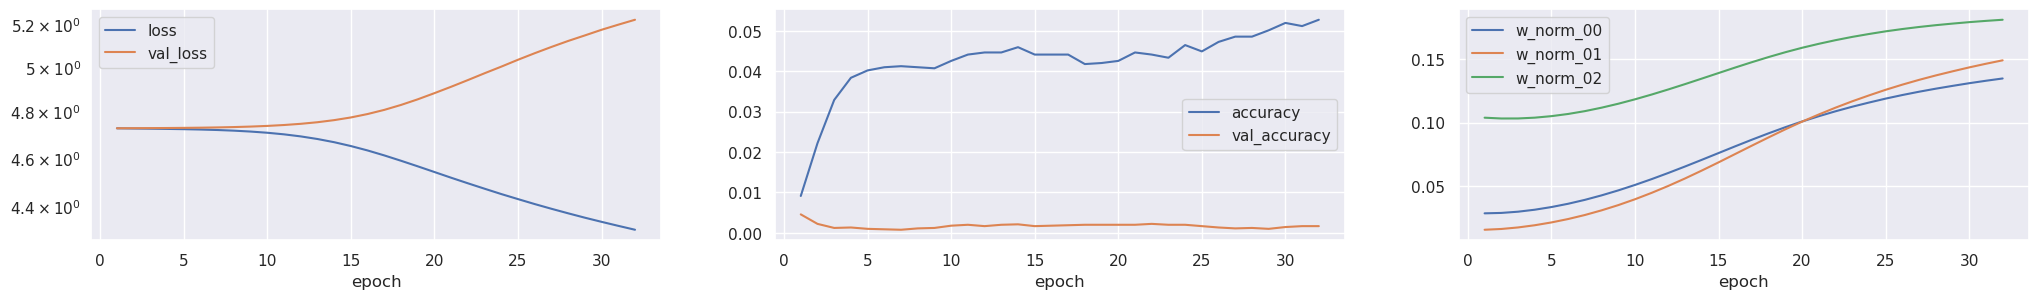

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(25,3))

sns.lineplot(data=run.history[["loss", "val_loss"]], ax=axs[0], dashes=False);
axs[0].set_yscale("log");

sns.lineplot(data=run.history[["accuracy", "val_accuracy"]], ax=axs[1], dashes=False);

sns.lineplot(data=weight_norm_logger.norms_dataframe(), ax=axs[2], dashes=False);

In [10]:
run.save_state(LOG_DIR, P, model)
weight_norm_logger.norms_to_csv(LOG_DIR)